In [1]:
import warnings
warnings.filterwarnings(action='ignore') # To show code clearly

In [2]:
import os
import csv
import scipy
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import GEOparse
gse = GEOparse.get_GEO("GSE56931", annotate_gpl='GPL10379', silent=True)

### Pre-processing

In [4]:
# Blood transcriptome data
sample_info_dict = {}
try : 
    for gsm_name, gsm in gse.gsms.items():
        subject, responder, gender, day, timepoint, group = gsm.metadata["title"][0].split(', ')
        subject = subject.split(' ')[1]
        responder = responder.split(' ')[0]
        day = day[3:]; timepoint = timepoint[4:].strip()

        sample_info_dict[gsm.metadata["geo_accession"][0]] = [subject, group, gender, responder, day, timepoint]
except:
    print(gsm_name)
col = ['subject', 'group', 'gender', 'responder', 'day', 'timepoint']
sample_info = pd.DataFrame.from_dict(sample_info_dict, orient='index', columns=col)

In [5]:
# Annotation table
gpl = gse.gpls['GPL10379'].table.dropna(subset=['GeneSymbol'])
annot_table = gsm.annotate(gpl, annotation_column="GeneSymbol")
annot_table = annot_table.drop(['VALUE'], axis=1)
annot_table = annot_table.set_index('ID_REF')

In [6]:
# Sleep condition groups
BS = sample_info[sample_info['group']=='baseline'].index.tolist()
SD = sample_info[sample_info['group']=='sleepdep'].index.tolist()
BS = list(set(BS) - set(sample_info[(sample_info.day == '1')].index))

BS_df = gse.pivot_samples('VALUE')[BS] # Quantile normalized signal intensity
SD_df = gse.pivot_samples('VALUE')[SD]

In [7]:
annot_dict = {k:v['GeneSymbol'] for k, v in annot_table.to_dict('index').items()}

BS_df.rename(index=annot_dict, inplace=True)
BS_df.drop((i for i in BS_df.index if type(i)==int), inplace=True)
BS_df = BS_df.groupby(BS_df.index).mean() #33475

SD_df.rename(index=annot_dict, inplace=True)
SD_df.drop((i for i in SD_df.index if type(i)==int), inplace=True)
SD_df = SD_df.groupby(SD_df.index).mean() #33475

In [8]:
# Subject dataframe
BS_phase = {(2,0):0, (2,4):4, (2,8):8, (2,12):12, (2,16):16, (2,20):20}
SD_phase = {(3,0):0, (3,4):4, (3,8):8, (3,12):12, (3,16):16, (3,20):20}

for subject in set(sample_info['subject']) :
    for group in ["BS", "SD"]:
        df = sample_info.loc[list(set(sample_info[(sample_info['subject']==subject)].index).intersection(set(vars()[group])))]
        df.day = [int(d) for d in df.day]
        df.timepoint = [int(t) for t in df.timepoint]
        df.sort_values(by=['day','timepoint'], inplace=True)
        df['phase'] = df.apply(lambda x: globals()[group+'_phase'][(x.day, x.timepoint)], axis=1)
        
        vars()[subject+'_'+group] = vars()[group+'_df'][df.index]
        idx = [i for i in vars()[group+'_df'].index if ('_at' not in i)&('tcag' not in i)&('hCG' not in i)]
        vars()[subject+'_'+group] = vars()[subject+'_'+group].loc[idx] #18661
        vars()[subject+'_'+group].columns = df.phase

### DEG search

In [9]:
# Mixed-model ANOVA
import pingouin as pg

DF = pd.DataFrame()
for subject in set(sample_info.subject):
    for group in ["BS", "SD"]:
        df = sample_info.loc[list(set(sample_info[(sample_info['subject']==subject)].index).intersection(set(vars()[group])))]
        df.day = [int(d) for d in df.day]
        df.timepoint = [int(t) for t in df.timepoint]
        df.sort_values(by=['day','timepoint'], inplace=True)
        df['phase'] = df.apply(lambda x: globals()[group+'_phase'][(x.day, x.timepoint)], axis=1)
        df = df[['subject','group','phase']]
        df['group'] = group
        
        if group == 'BS':
            df_bs = pd.merge(df[(df['subject']==subject)&(df['group']==group)], vars()[subject+'_BS'].T, how='outer', left_on='phase', right_index=True)
            df_bs['subject'] = subject + '_BS'
        elif group == 'SD':
            df_sd = pd.merge(df[(df['subject']==subject)&(df['group']==group)], vars()[subject+'_SD'].T, how='outer', left_on='phase', right_index=True)
            df_sd['subject'] = subject + '_SD'
    DF = pd.concat([DF, df_bs, df_sd])

In [10]:
DEG_anova = []
if os.path.isfile('../data/SD-GSE56931/ANOVA621.csv'):
    with open('../data/SD-GSE56931/ANOVA621.csv','r') as fr :
        reader = csv.reader(fr)
        for line in reader:
            DEG_anova.append(line)
    DEG_anova = DEG_anova[0]
    print(len(DEG_anova))
else:
    for gene in DF.columns[3:]:
        results = pg.mixed_anova(dv=gene, between='group', within='phase', subject='subject', data=DF[['subject','group','phase',gene]])
        reject, corrected_pval = pg.multicomp(results['p-unc'], method='fdr_bh')
        if corrected_pval[2] < 0.05:
            DEG_anova.append(gene)
    print(len(DEG_anova)) #621

621


### Stationary test

In [11]:
def fillna(data, col=list(range(0,24,4))):
    df = pd.DataFrame(data, columns=col)
    df = df.T.interpolate()
    df = df.fillna(method='ffill') #fillna with previous time value
    df = df.fillna(method='bfill') #fillna with next time value
    return df.T

In [12]:
# Stationary test (Augemented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller

if os.path.isfile('../data/SD-GSE56931/nonstationary.csv'):
    nonstationary_list = []
    with open('../data/SD-GSE56931/nonstationary.csv', 'r') as fr :
        reader = csv.reader(fr)
        for line in reader:
            nonstationary_list.append(line) 
    nonstationary_list = nonstationary_list[0]
    print(len(nonstationary_list))
else :
    nonstationary = dict()
    for subject in set(sample_info['subject']) :
        df = fillna(vars()[subject+'_BS'])
        if len(df.columns) == 6 :  # samples should have all time-points
            sns = []
            try :
                for i in df.index:
                    if adfuller(df.loc[i])[1] >= 0.05 :
                        sns.append(i)
                nonstationary[subject] = sns
            except : print("X",subject, i)

    nonstationary_list = set.union(*map(set, nonstationary.values())) 
    print(len(nonstationary_list)) #18660

18660


### Oscillation test

In [13]:
# Cosinor analysis - 24 periodicity
from CosinorPy import cosinor, cosinor1

if os.path.isfile('../data/SD-GSE56931/oscillation_BS.csv') & os.path.isfile('../data/SD-GSE56931/oscillation_SD.csv') :
    oscillation_BS = []; oscillation_SD = []
    with open('../data/SD-GSE56931/oscillation_BS.csv','r') as fr:
        reader = csv.reader(fr)
        for line in reader:
            oscillation_BS.append(line)
    oscillation_BS = oscillation_BS[0]
    
    with open('../data/SD-GSE56931/oscillation_SD.csv','r') as fr:
        reader = csv.reader(fr)
        for line in reader:
            oscillation_SD.append(line)
    oscillation_SD = oscillation_SD[0]
    print(len(oscillation_BS), len(oscillation_SD)) #18914, 18064
    
else :
    cosinor_dict = {}
    for subject in set(sample_info['subject']) :
        cosinor_dict[subject] = {}
        for group in ["BS","SD"]:
            cosinor_dict[subject][group] = pd.DataFrame()
            if len(vars()[subject+"_"+group].columns) == 0 : pass
            else :
                df = fillna(vars()[subject+"_"+group])
                for i in vars()[subject+"_"+group].index :
                    cosinor_df = pd.DataFrame({'x':np.linspace(0,24,7)[:-1], 'y':df.loc[i].values, 'test':['test1']*6})
                    results = cosinor.fit_group(cosinor_df, period=24, plot=False)
                    df_best_models = cosinor.get_best_models(cosinor_df, results)
                    df_best_models['test'] = i
                    cosinor_dict[subject][group] = pd.concat([cosinor_dict[subject][group], df_best_models])

    for group in ["BS","SD"]:
        vars()["oscillation_"+group] = []
        for subject, cosinor_res in cosinor_dict.items():
            if len(cosinor_res[group]) != 0 :
                vars()["oscillation_"+group].extend(cosinor_res[group][cosinor_res[group]['p'] < 0.05]['test'])
    
oscillation_genes = set(oscillation_BS).intersection(set(nonstationary_list))
print(len(oscillation_genes)) #11529

18914 18064
11529


### Network construction

In [14]:
# Gene co-expressed network
G = nx.Graph()
DEGs = list(set(oscillation_genes).intersection(set(DEG_anova))) # You can get DEGs from ./data/SD-GSE56931/DEG435.csv
G.add_nodes_from(DEGs) #435

In [15]:
# Phase dataframe
protocols = []
for phase in range(0,24,4):
    for group in ['BS', 'SD']:
        df = sample_info.loc[vars()[group]]
        df.day = [int(d) for d in df.day]
        df.timepoint = [int(t) for t in df.timepoint]
        df.sort_values(by=['day','timepoint'], inplace=True)
        df['phase'] = df.apply(lambda x: globals()[group+'_phase'][(x.day, x.timepoint)], axis=1)
        
        name = group+'_'+str(phase)
        vars()[name] = df[df.phase == phase].index
        vars()[name+'_df'] = vars()[group+'_df'][vars()[name]].loc[DEGs]
        protocols.append(name)

In [16]:
# Make the edges
from tqdm import tqdm

for protocol in protocols:
    if os.path.isfile('../data/SD-GSE56931/network/{}_edges.csv'.format(protocol)):
        vars()[protocol+'_edges'] = []
        with open('../data/SD-GSE56931/network/{}_edges.csv'.format(protocol)) as fr:
            reader = csv.reader(fr)
            for line in reader:
                vars()[protocol+'_edges'].append(line)
        vars()[protocol+'_edges'] = vars()[protocol+'_edges'][0]
        vars()[protocol+'_filtered_edge'] = [eval(edge) for edge in vars()[protocol+'_edges'] if edge.split(', ')[-1][:-1] != '0']
        
    else:
        df = vars()[protocol+'_df']
        edges = []
        for i in tqdm(range(len(df.index))):
            for j in range(len(df.index)):
                if i < j :
                    r, p = scipy.stats.pearsonr(df.iloc[i], df.iloc[j])
                    if p < 0.05:
                        edges.append((df.index[i], df.index[j], r)) 
                    else: edges.append((df.index[i], df.index[j], 0))
        vars()[protocol+'_edges'] = edges
        vars()[protocol+'_filtered_edge'] = [edge for edge in vars()[protocol+'_edges'] if edge[2] != 0]
        
    globals()[protocol+'_graph'] = G.copy() # nodes : 435
    globals()[protocol+'_graph'].add_weighted_edges_from(vars()[protocol+'_filtered_edge'])

In [17]:
# Subject networks
for subject in set(sample_info.subject):
    for protocol in protocols:
        vars()[protocol+'_'+subject] = []
        if os.path.isfile('../data/SD-GSE56931/network/subjects/{}.csv'.format(protocol+'_'+subject)):
            with open('../data/SD-GSE56931/network/subjects/{}.csv'.format(protocol+'_'+subject)) as fr:
                reader = csv.reader(fr)
                for line in reader:
                    vars()[protocol+'_'+subject].append(line)
            vars()[protocol+'_'+subject] = vars()[protocol+'_'+subject][0]
            vars()[protocol+'_'+subject] = [eval(edge) for edge in vars()[protocol+'_'+subject] if edge.split(', ')[-1][:-1] != '0']
        
        else:
            print(protocol+'_'+subject)
            df = vars()[protocol+'_df']
            sample_name = list(set(sample_info[(sample_info.subject==subject)].index).intersection(set(vars()[protocol])))
            if len(sample_name) > 0 :
                for g_i, g_j, r in vars()[protocol+'_filtered_edge']:
                    ia = df.loc[g_i, ~df.columns.str.contains(sample_name[0])].tolist()
                    ib = df.loc[g_j, ~df.columns.str.contains(sample_name[0])].tolist()
                    r_new, p_new = scipy.stats.pearsonr(ia, ib)
                    if (p_new < 0.05) & (np.abs(r)-np.abs(r_new) > 0):
                        vars()[protocol+'_'+subject].append((g_i, g_j, r_new))
            else :
                vars()[protocol+'_'+subject] = vars()[protocol+'_filtered_edge']
        
        vars()['G_'+protocol+'_'+subject] = G.copy() # nodes : 435
        vars()['G_'+protocol+'_'+subject].add_weighted_edges_from(vars()[protocol+'_'+subject])

### Network topology analysis

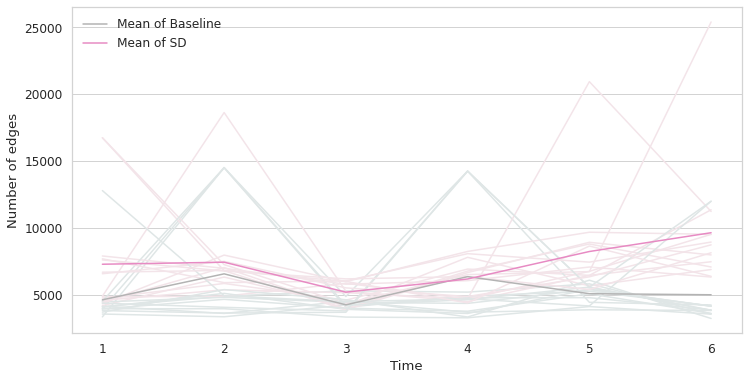

In [30]:
# Edge count
Edge_subjects = {'BS':{s:[] for s in set(sample_info.subject)},'SD':{s:[] for s in set(sample_info.subject)}}
for protocol in protocols:
    for subject in set(sample_info.subject):
        Edge_subjects[protocol[:2]][subject].append(len(vars()['G_'+protocol+'_'+subject].edges()))
Edge_df_BS = pd.DataFrame.from_dict(Edge_subjects['BS'], orient='index', columns=np.arange(0,24,4))
Edge_df_SD = pd.DataFrame.from_dict(Edge_subjects['SD'], orient='index', columns=np.arange(0,24,4))

sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
for subject in set(sample_info.subject):
    plt.plot(Edge_df_BS.loc[subject,:], color='#DFE6E6')
    plt.plot(Edge_df_SD.loc[subject,:], color='#F3E4E9')
plt.plot(Edge_df_BS.mean(),color=sns.color_palette('Set2')[-1], label='Mean of Baseline')
plt.plot(Edge_df_SD.mean(),color=sns.color_palette('Set2')[3], label='Mean of SD')
plt.xticks(np.arange(0,24,4), labels=[1,2,3,4,5,6])
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Number of edges')
plt.legend(frameon=False)
plt.show()

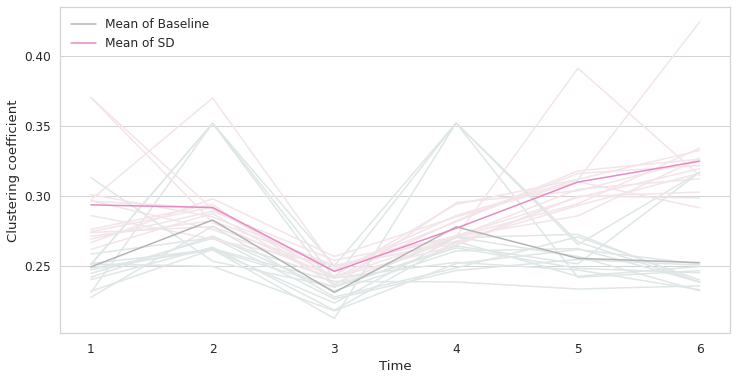

In [31]:
# Clustering coefficient
CC_subjects = {'BS':{s:[] for s in set(sample_info.subject)},'SD':{s:[] for s in set(sample_info.subject)}}
for protocol in protocols:
    for subject in set(sample_info.subject):
        graph = vars()['G_'+protocol+'_'+subject]
        CC_subjects[protocol[:2]][subject].append(np.average(list(nx.clustering(graph, weight='weight').values())))
CC_df_BS = pd.DataFrame.from_dict(CC_subjects['BS'], orient='index', columns=np.arange(0,24,4))
CC_df_SD = pd.DataFrame.from_dict(CC_subjects['SD'], orient='index', columns=np.arange(0,24,4))

sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
for subject in set(sample_info.subject):
    plt.plot(CC_df_BS.loc[subject,:], color='#DFE6E6')
    plt.plot(CC_df_SD.loc[subject,:], color='#F3E4E9')
plt.plot(CC_df_BS.mean(),color=sns.color_palette('Set2')[-1], label='Mean of Baseline')
plt.plot(CC_df_SD.mean(),color=sns.color_palette('Set2')[3], label='Mean of SD')
plt.xticks(np.arange(0,24,4), labels=[1,2,3,4,5,6])
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Clustering coefficient')
plt.legend(frameon=False)
plt.show()

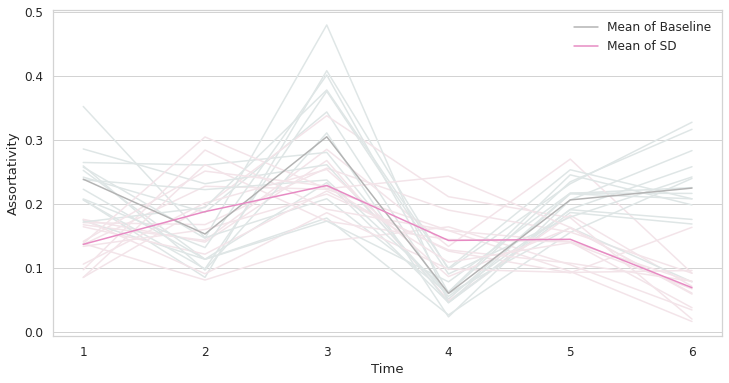

In [32]:
# Assortativity
ASS_subjects = {'BS':{s:[] for s in set(sample_info.subject)},'SD':{s:[] for s in set(sample_info.subject)}}
for protocol in protocols:
    for subject in set(sample_info.subject):
        graph = vars()['G_'+protocol+'_'+subject]
        ASS_subjects[protocol[:2]][subject].append(nx.degree_pearson_correlation_coefficient(graph, weight='weight'))
ASS_df_BS = pd.DataFrame.from_dict(ASS_subjects['BS'], orient='index', columns=np.arange(0,24,4))
ASS_df_SD = pd.DataFrame.from_dict(ASS_subjects['SD'], orient='index', columns=np.arange(0,24,4))

sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
for subject in set(sample_info.subject):
    plt.plot(ASS_df_BS.loc[subject,:], color='#DFE6E6')
    plt.plot(ASS_df_SD.loc[subject,:], color='#F3E4E9')
plt.plot(ASS_df_BS.mean(),color=sns.color_palette('Set2')[-1], label='Mean of Baseline')
plt.plot(ASS_df_SD.mean(),color=sns.color_palette('Set2')[3], label='Mean of SD')
plt.xticks(np.arange(0,24,4), labels=[1,2,3,4,5,6])
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Assortativity')
plt.legend(frameon=False)
plt.show()

In [22]:
# Graph entropy for weighted graph
from __future__ import division

def centrality_distribution(G):
    centrality = nx.eigenvector_centrality_numpy(G, weight='weight').values()
    centrality = list(centrality)
    centrality = np.array(centrality) / sum(centrality)
    return centrality

def graph_entropy(dist):
    dist = np.asarray(dist)
    ent = np.nansum( dist *  np.log2( 1/dist ) )
    return ent

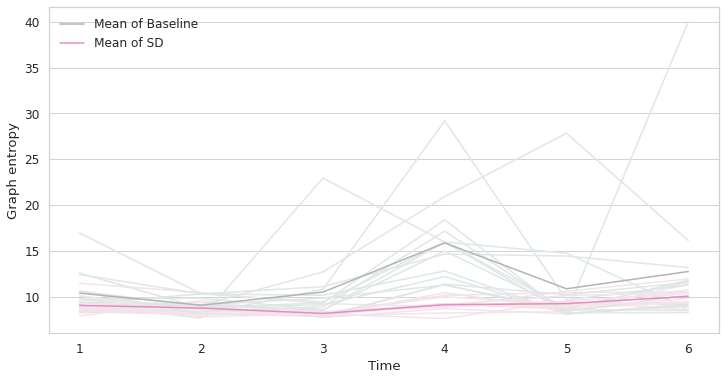

In [33]:
# Graph entropy
GE_subjects = {'BS':{s:[] for s in set(sample_info.subject)},'SD':{s:[] for s in set(sample_info.subject)}}
for protocol in protocols:
    for subject in set(sample_info.subject):
        graph = vars()['G_'+protocol+'_'+subject]
        d = centrality_distribution(graph)
        GE_subjects[protocol[:2]][subject].append(graph_entropy(d))
GE_df_BS = pd.DataFrame.from_dict(GE_subjects['BS'], orient='index', columns=np.arange(0,24,4))
GE_df_SD = pd.DataFrame.from_dict(GE_subjects['SD'], orient='index', columns=np.arange(0,24,4))

sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
for subject in set(sample_info.subject):
    plt.plot(GE_df_BS.loc[subject,:], color='#DFE6E6')
    plt.plot(GE_df_SD.loc[subject,:], color='#F3E4E9')
plt.plot(GE_df_BS.mean(),color=sns.color_palette('Set2')[-1], label='Mean of Baseline')
plt.plot(GE_df_SD.mean(),color=sns.color_palette('Set2')[3], label='Mean of SD')
plt.xticks(np.arange(0,24,4), labels=[1,2,3,4,5,6])
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Graph entropy')
plt.legend(frameon=False)
plt.show()

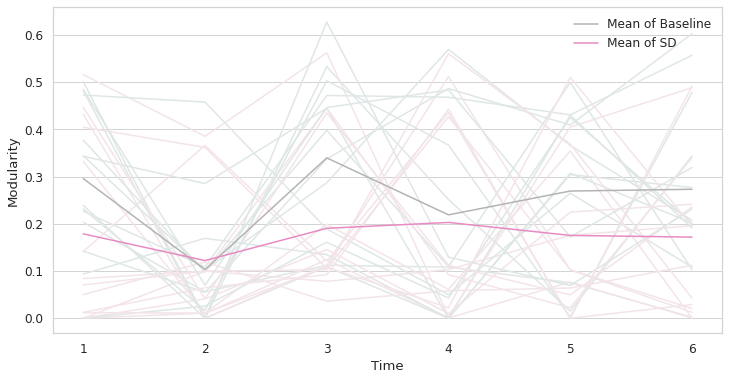

In [34]:
# Modularity
MD_subjects = {'BS':{s:[] for s in set(sample_info.subject)},'SD':{s:[] for s in set(sample_info.subject)}}
for protocol in protocols:
    for subject in set(sample_info.subject):
        graph = vars()['G_'+protocol+'_'+subject]
        MD_subjects[protocol[:2]][subject].append(nx.community.modularity(graph, nx.community.label_propagation_communities(graph)))
MD_df_BS = pd.DataFrame.from_dict(MD_subjects['BS'], orient='index', columns=np.arange(0,24,4))
MD_df_SD = pd.DataFrame.from_dict(MD_subjects['SD'], orient='index', columns=np.arange(0,24,4))

sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
for subject in set(sample_info.subject):
    plt.plot(MD_df_BS.loc[subject,:], color='#DFE6E6')
    plt.plot(MD_df_SD.loc[subject,:], color='#F3E4E9')
plt.plot(MD_df_BS.mean(),color=sns.color_palette('Set2')[-1], label='Mean of Baseline')
plt.plot(MD_df_SD.mean(),color=sns.color_palette('Set2')[3], label='Mean of SD')
plt.xticks(np.arange(0,24,4), labels=[1,2,3,4,5,6])
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Modularity')
plt.legend(frameon=False, loc='upper right')
plt.show()

### Sleep homeostasis - Circadian effects

In [25]:
# Linear mixed-effects model

import math
from scipy.optimize import curve_fit

def df_interpolate(dic):
    df = pd.DataFrame.from_dict(dic, orient='index').T
    df = df.replace(0,np.nan).interpolate()
    df = df.T[df.isna().sum() != 10]
    for i in df[df[0].isna()].index:
        n = df.loc[i].isna().sum()
        df.loc[i][0:n] = df.loc[i][n]
    return df

def func(x, a, b, c, d, e):
    return a + b*np.log(x) + c*np.cos(2*math.pi*(x+d)/24) + e

def curve_fitting(subject_dict, time=None):
    if time == 'night' : 
        dict_df = {'BS':pd.DataFrame(subject_dict['BS']).T[[0,1,2]], 'SD':pd.DataFrame(subject_dict['SD']).T[[0,1,2]]}
    elif time == 'day':
        dict_df = {'BS':pd.DataFrame(subject_dict['BS']).T[[3,4,5]], 'SD':pd.DataFrame(subject_dict['SD']).T[[3,4,5]]}
    else :
        dict_df = {'BS':pd.DataFrame(subject_dict['BS']).T, 'SD':pd.DataFrame(subject_dict['SD']).T}
    Hparam = {'BS':{}, 'SD':{}}; std_err = {'BS':{}, 'SD':{}}
    for subject in set(dict_df['BS'].index).intersection(set(dict_df['SD'].index)) :
        Hparam['BS'][subject] = None; Hparam['SD'][subject] = None;
        std_err['BS'][subject] = None; std_err['SD'][subject] = None;
        for prot in ['BS','SD']:
            if time != None : 
                xdata = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
                dict_df[prot].columns = [1,6,11]
                ydata = fillna(dict_df[prot], col=[i+1 for i in range(12)]).loc[subject].tolist()
            else : 
                xdata = np.array([0,4,8,12,16,20,24,28,32,36]) + 1
                ydata = dict_df[prot].loc[subject].tolist()
            popt, pcov = curve_fit(func, xdata, ydata, absolute_sigma=True)
            Hparam[prot][subject] = popt
            std_err[prot][subject] = np.sqrt(np.diag(pcov))
    return Hparam, std_err

In [26]:
# Additional data points
for subject in set(sample_info['subject']) :
    for group in ["BS", "SD"]:
        for t in range(0,40,4):
            name = group+'_'+str(t)+'_40h_'+subject
            vars()[name] = []
            if os.path.isfile('../data/SD-GSE56931/network-40h/subjects/{}.csv'.format(name)):
                with open('../data/SD-GSE56931/network-40h/subjects/{}.csv'.format(name), 'r') as fr:
                    reader = csv.reader(fr)
                    for line in reader:
                        vars()[name].append(line)
                vars()[name] = vars()[name][0]
                vars()[name] = [eval(edge) for edge in vars()[name] if edge.split(', ')[-1][:-1] != '0']
                vars()['G_'+name] = G.copy()
                vars()['G_'+name].add_weighted_edges_from(vars()[name])
            else :
                print("Please contact to the author.")

In [27]:
# Network features for additional data points
protocols_40h = [group+'_'+str(t)+'_40h_'+subject for subject in set(sample_info['subject']) for group in ["BS", "SD"] for t in range(0,40,4)]

CC_subjects_40h = {'BS':{s:[] for s in set(sample_info.subject)},'SD':{s:[] for s in set(sample_info.subject)}}
ASS_subjects_40h = {'BS':{s:[] for s in set(sample_info.subject)},'SD':{s:[] for s in set(sample_info.subject)}}
GE_subjects_40h = {'BS':{s:[] for s in set(sample_info.subject)},'SD':{s:[] for s in set(sample_info.subject)}}
MD_subjects_40h = {'BS':{s:[] for s in set(sample_info.subject)},'SD':{s:[] for s in set(sample_info.subject)}}
for subject in set(sample_info['subject']) :
    for group in ["BS", "SD"]:
        for t in range(0,40,4):
            name = group+'_'+str(t)+'_40h_'+subject
            graph = vars()['G_'+name]
            CC_subjects_40h[group][subject].append(np.average(list(nx.clustering(graph, weight='weight').values())))
            ASS_subjects_40h[group][subject].append(nx.degree_pearson_correlation_coefficient(graph, weight='weight'))
            d = centrality_distribution(graph)
            GE_subjects_40h[group][subject].append(graph_entropy(d))
            MD_subjects_40h[group][subject].append(nx.community.modularity(graph, nx.community.label_propagation_communities(graph)))
            
Hparam_CC, std_err_CC = curve_fitting(CC_subjects_40h)
Hparam_ASS, std_err_ASS = curve_fitting(ASS_subjects_40h)
Hparam_GE, std_err_GE = curve_fitting(GE_subjects_40h)
Hparam_MD, std_err_MD = curve_fitting(MD_subjects_40h)

Hparam_GE['BS'] = {k:v/100 for k,v in Hparam_GE['BS'].items()} #normalize
Hparam_GE['SD'] = {k:v/100 for k,v in Hparam_GE['SD'].items()}

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ASS_BS v.s. ASS_SD: t-test independent samples, P_val=7.370e-03 stat=2.907e+00
CC_BS v.s. CC_SD: t-test independent samples, P_val=4.403e-07 stat=-6.676e+00
GE_BS v.s. GE_SD: t-test independent samples, P_val=9.969e-04 stat=3.708e+00
MD_BS v.s. MD_SD: t-test independent samples, P_val=1.575e-01 stat=1.455e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ASS_BS v.s. ASS_SD: t-test independent samples, P_val=7.944e-03 stat=-2.876e+00
CC_BS v.s. CC_SD: t-test independent samples, P_val=3.247e-02 stat=2.259e+00
GE_BS v.s. GE_SD: t-test independent samples, P_val=8.546e-01 stat=1.851e-01
MD_BS v.s. MD_SD: t-test independent samples, P_val=6.416e-01 stat=4.709e-01


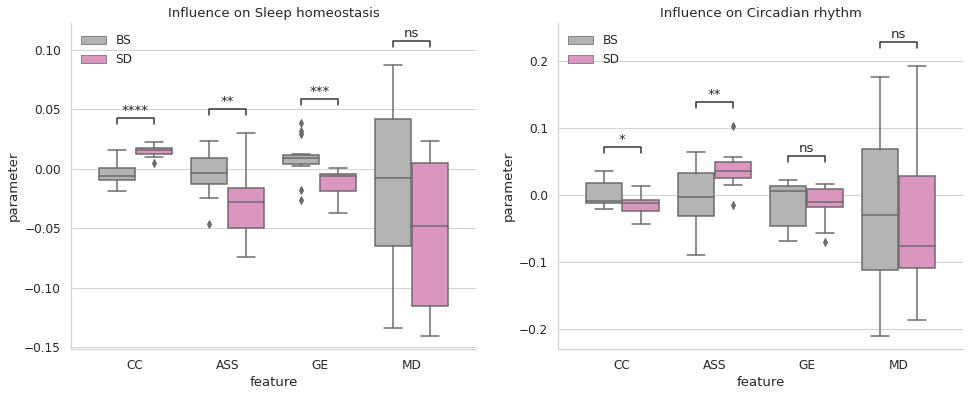

In [29]:
import statannot
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,6))

df_box = pd.DataFrame(columns=['feature','parameter','hue'])
for k, v in {'CC':'Hparam_CC', 'ASS':'Hparam_ASS', 'GE':'Hparam_GE', 'MD':'Hparam_MD'}.items():
    for group in ['BS', 'SD']:
        df_box = pd.concat([df_box, pd.DataFrame({'feature': [k]*14, #number of subjects
                                                  'parameter':pd.DataFrame(vars()[v][group]).iloc[1].tolist(),
                                                  'hue':[group]*14})], ignore_index=True)

sns.boxplot(ax=axes[0], x='feature', y='parameter', hue='hue', data=df_box, palette=[sns.color_palette('Set2')[-1],sns.color_palette('Set2')[3]]) #sns.color_palette().reverse()
axes[0], results = statannot.add_stat_annotation(
    axes[0],
    data=df_box,
    x='feature',
    y='parameter',
    hue='hue',
    box_pairs=[
        (("CC", "BS"), ("CC", "SD")),
        (("ASS", "BS"), ("ASS", "SD")),
        (("GE", "BS"), ("GE", "SD")),
        (("MD", "BS"), ("MD", "SD"))
    ],
    test="t-test_ind",
    comparisons_correction=None,    
    text_format="star",
    loc="inside",
)

df_box = pd.DataFrame(columns=['feature','parameter','hue'])
for k, v in {'CC':'Hparam_CC', 'ASS':'Hparam_ASS', 'GE':'Hparam_GE', 'MD':'Hparam_MD'}.items():
    for group in ['BS', 'SD']:
        df_box = pd.concat([df_box, pd.DataFrame({'feature': [k]*14, #number of subjects
                                                  'parameter':pd.DataFrame(vars()[v][group]).iloc[2].tolist(),
                                                  'hue':[group]*14})], ignore_index=True)

sns.boxplot(ax=axes[1], x='feature', y='parameter', hue='hue', data=df_box, palette=[sns.color_palette('Set2')[-1],sns.color_palette('Set2')[3]])
axes[1], results = statannot.add_stat_annotation(
    axes[1],
    data=df_box,
    x='feature',
    y='parameter',
    hue='hue',
    box_pairs=[
        (("CC", "BS"), ("CC", "SD")),
        (("ASS", "BS"), ("ASS", "SD")),
        (("GE", "BS"), ("GE", "SD")),
        (("MD", "BS"), ("MD", "SD"))
    ],
    test="t-test_ind",
    comparisons_correction=None,
    text_format="star",
    loc="inside",
)

axes[0].set_title("Influence on Sleep homeostasis")
axes[1].set_title("Influence on Circadian rhythm")
axes[0].grid(True, axis='y', color='lightgrey'); axes[1].grid(True, axis='y', color='lightgrey')
axes[0].legend(frameon=False); axes[1].legend(frameon=False)
#plt.savefig('../results/SD_lme.png', dpi=300)
sns.despine()

### Dynamics in network topological features

In [86]:
def circa_func(x, a, b, c, d):
    return a + b*np.cos(2*np.pi*x/24 + c) + d

def func(x, a, b, c, e):
    return a + b*np.log(x) + c*np.cos(2*math.pi*(x-2*math.pi)/24) + e

def curve_fitting(subject_dict, time=None):
    if time == 'night' : 
        dict_df = {'BS':pd.DataFrame(subject_dict['BS']).T[[0,1,2]], 'SD':pd.DataFrame(subject_dict['SD']).T[[0,1,2]]}
    elif time == 'day':
        dict_df = {'BS':pd.DataFrame(subject_dict['BS']).T[[3,4,5]], 'SD':pd.DataFrame(subject_dict['SD']).T[[3,4,5]]}
    else :
        dict_df = {'BS':pd.DataFrame(subject_dict['BS']).T, 'SD':pd.DataFrame(subject_dict['SD']).T}
    Hparam = {'BS':{}, 'SD':{}}; std_err = {'BS':{}, 'SD':{}}
    for subject in set(dict_df['BS'].index).intersection(set(dict_df['SD'].index)) :
        Hparam['BS'][subject] = None; Hparam['SD'][subject] = None;
        std_err['BS'][subject] = None; std_err['SD'][subject] = None;
        for prot in ['BS','SD']:
            if time != None : 
                xdata = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
                dict_df[prot].columns = [1,6,11]
                ydata = fillna(dict_df[prot], col=[i+1 for i in range(12)]).loc[subject].tolist()
            else : 
                xdata = np.array([0,4,8,12,16,20,24,28,32,36]) + 1
                ydata = dict_df[prot].loc[subject].tolist()
            popt, pcov = curve_fit(func, xdata, ydata, absolute_sigma=True)
            Hparam[prot][subject] = popt
            std_err[prot][subject] = np.sqrt(np.diag(pcov))
    return Hparam, std_err

In [87]:
Hparam_CC_night = {'BS':None, 'SD':None}; Hparam_CC_day = {'BS':None, 'SD':None}

S_CC_night = {'BS':{s:[] for s in set(sample_info.subject)}, 'SD':{s:[] for s in set(sample_info.subject)}}
C_CC_night = {'BS':{s:[] for s in set(sample_info.subject)}, 'SD':{s:[] for s in set(sample_info.subject)}}
S_CC_day = {'BS':{s:[] for s in set(sample_info.subject)}, 'SD':{s:[] for s in set(sample_info.subject)}}
C_CC_day = {'BS':{s:[] for s in set(sample_info.subject)}, 'SD':{s:[] for s in set(sample_info.subject)}}

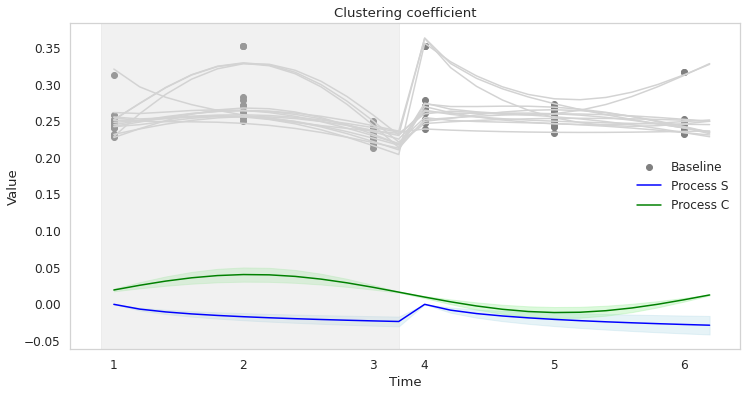

In [88]:
# Dynamics in Clustering coefficient for BS group
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)

df_night = pd.DataFrame(CC_subjects['BS']).T[[0,1,2]]
df_night.columns = [1,6,11]; df_night = fillna(df_night, col=[i+1 for i in range(12)])
df_day = pd.DataFrame(CC_subjects['BS']).T[[3,4,5]]
df_day.columns = [1,6,11]; df_day = fillna(df_day, col=[i+1 for i in range(12)])
Hparam_CC_night = curve_fitting(CC_subjects, time='night')[0]
Hparam_CC_day = curve_fitting(CC_subjects, time='day')[0]

fig, ax = plt.subplots()
time = np.array([1,6,11,13,18,23])
plt.scatter(time, np.concatenate([np.mean(df_night, axis=0),np.mean(df_day, axis=0)])[time-1], color='grey', label='Baseline')

for subject in set(sample_info.subject):
    plt.scatter(time, np.concatenate([df_night.loc[subject],df_day.loc[subject]])[time-1], color='grey')
    param_night = Hparam_CC_night['BS'][subject]; param_day = Hparam_CC_day['BS'][subject]
    y_night = func(np.arange(1,13),param_night[0],param_night[1],param_night[2],param_night[3])
    y_day = func(np.arange(1,13),param_day[0],param_day[1],param_day[2],param_day[3])
    plt.plot(np.arange(1,25), np.concatenate([y_night, y_day]), color='lightgrey')
    S_CC_night['BS'][subject] = param_night[1]*np.log(np.arange(1,13))
    C_CC_night['BS'][subject] = param_night[2]*np.cos(2*math.pi*(np.arange(1,13)-2*math.pi)/24)
    S_CC_day['BS'][subject] = param_day[1]*np.log(np.arange(1,13))
    C_CC_day['BS'][subject] = param_day[2]*np.cos(2*math.pi*(np.arange(1,13)-2*math.pi)/24)
    
ys = np.concatenate([pd.DataFrame(S_CC_night['BS']).mean(axis=1), pd.DataFrame(S_CC_day['BS']).mean(axis=1)])
error_s = np.concatenate([pd.DataFrame(S_CC_night['BS']).sem(axis=1), pd.DataFrame(S_CC_day['BS']).sem(axis=1)])
ax.plot(np.arange(1,25), ys, color='blue', label='Process S')
ax.fill_between(np.arange(1,25), ys - error_s, ys + error_s, color='lightblue', alpha=0.3)

yc = np.concatenate([pd.DataFrame(C_CC_night['BS']).mean(axis=1), pd.DataFrame(C_CC_day['BS']).mean(axis=1)])
yc_c = circa_func(np.arange(1,25), *curve_fit(circa_func, np.arange(1,25), yc)[0])
error_c = np.concatenate([pd.DataFrame(C_CC_night['BS']).sem(axis=1), pd.DataFrame(C_CC_day['BS']).sem(axis=1)])
ax.plot(np.arange(1,25), yc_c, color='green', label='Process C')
ax.fill_between(np.arange(1,25), yc_c - error_c, yc_c + error_c, color='lightgreen', alpha=0.3)
ax.axvspan(0.5, 12, color='lightgray', alpha=0.3)
plt.title("Clustering coefficient")
plt.legend(frameon=False)
plt.xlabel("Time"); plt.ylabel("Value")
plt.xticks(time,[1,2,3,4,5,6])
plt.show()

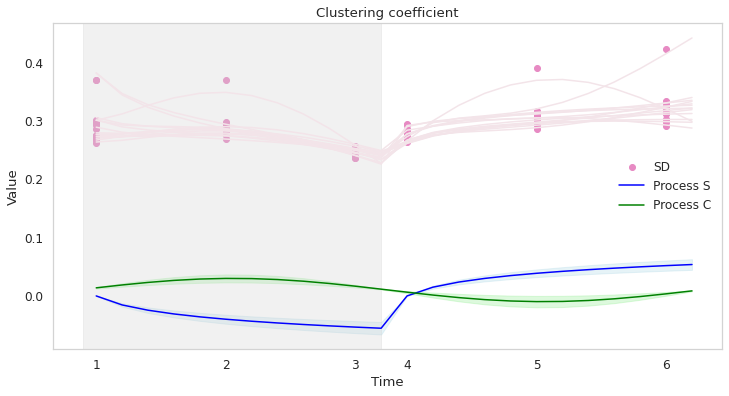

In [89]:
# Dynamics in Clustering coefficient for SD group
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)

df_night = pd.DataFrame(CC_subjects['SD']).T[[0,1,2]]
df_night.columns = [1,6,11]; df_night = fillna(df_night, col=[i+1 for i in range(12)])
df_day = pd.DataFrame(CC_subjects['SD']).T[[3,4,5]]
df_day.columns = [1,6,11]; df_day = fillna(df_day, col=[i+1 for i in range(12)])

fig, ax = plt.subplots()
time = np.array([1,6,11,13,18,23])
plt.scatter(time, np.concatenate([np.mean(df_night, axis=0),np.mean(df_day, axis=0)])[time-1], color=sns.color_palette('Set2')[3], label='SD')

for subject in set(sample_info.subject):
    plt.scatter(time, np.concatenate([df_night.loc[subject],df_day.loc[subject]])[time-1], color=sns.color_palette('Set2')[3])
    param_night = Hparam_CC_night['SD'][subject]; param_day = Hparam_CC_day['SD'][subject]
    y_night = func(np.arange(1,13),param_night[0],param_night[1],param_night[2],param_night[3])
    y_day = func(np.arange(1,13),param_day[0],param_day[1],param_day[2],param_day[3])
    plt.plot(np.arange(1,25), np.concatenate([y_night, y_day]), color='#F3E4E9')
    S_CC_night['SD'][subject] = param_night[1]*np.log(np.arange(1,13))
    C_CC_night['SD'][subject] = param_night[2]*np.cos(2*math.pi*(np.arange(1,13)-2*math.pi)/24)
    S_CC_day['SD'][subject] = param_day[1]*np.log(np.arange(1,13))
    C_CC_day['SD'][subject] = param_day[2]*np.cos(2*math.pi*(np.arange(1,13)-2*math.pi)/24)
    
ys = np.concatenate([pd.DataFrame(S_CC_night['SD']).mean(axis=1), pd.DataFrame(S_CC_day['SD']).mean(axis=1)])
error_s = np.concatenate([pd.DataFrame(S_CC_night['SD']).sem(axis=1), pd.DataFrame(S_CC_day['SD']).sem(axis=1)])
ax.plot(np.arange(1,25), ys, color='blue', label='Process S')
ax.fill_between(np.arange(1,25), ys - error_s, ys + error_s, color='lightblue', alpha=0.3)

yc = np.concatenate([pd.DataFrame(C_CC_night['SD']).mean(axis=1), pd.DataFrame(C_CC_day['SD']).mean(axis=1)])
yc_c = circa_func(np.arange(1,25), *curve_fit(circa_func, np.arange(1,25), yc)[0])
error_c = np.concatenate([pd.DataFrame(C_CC_night['SD']).sem(axis=1), pd.DataFrame(C_CC_day['SD']).sem(axis=1)])
ax.plot(np.arange(1,25), yc_c, color='green', label='Process C')
ax.fill_between(np.arange(1,25), yc_c - error_c, yc_c + error_c, color='lightgreen', alpha=0.3)
ax.axvspan(0.5, 12, color='lightgray', alpha=0.3)
plt.title("Clustering coefficient")
plt.legend(frameon=False)
plt.xlabel("Time"); plt.ylabel("Value")
plt.xticks(time,[1,2,3,4,5,6])
plt.show()

In [ ]:
Hparam_ASS_night = {'BS':None, 'SD':None}; Hparam_ASS_day = {'BS':None, 'SD':None}

S_ASS_night = {'BS':{s:[] for s in set(sample_info.subject)}, 'SD':{s:[] for s in set(sample_info.subject)}}
C_ASS_night = {'BS':{s:[] for s in set(sample_info.subject)}, 'SD':{s:[] for s in set(sample_info.subject)}}
S_ASS_day = {'BS':{s:[] for s in set(sample_info.subject)}, 'SD':{s:[] for s in set(sample_info.subject)}}
C_ASS_day = {'BS':{s:[] for s in set(sample_info.subject)}, 'SD':{s:[] for s in set(sample_info.subject)}}

In [ ]:
# Dynamics in Assortativity for BS group
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)

df_night = pd.DataFrame(ASS_subjects['BS']).T[[0,1,2]]
df_night.columns = [1,6,11]; df_night = fillna(df_night, col=[i+1 for i in range(12)])
df_day = pd.DataFrame(ASS_subjects['BS']).T[[3,4,5]]
df_day.columns = [1,6,11]; df_day = fillna(df_day, col=[i+1 for i in range(12)])
Hparam_ASS_night = curve_fitting(ASS_subjects, time='night')[0]
Hparam_ASS_day = curve_fitting(ASS_subjects, time='day')[0]

fig, ax = plt.subplots()
time = np.array([1,6,11,13,18,23])
plt.scatter(time, np.concatenate([np.mean(df_night, axis=0),np.mean(df_day, axis=0)])[time-1], color='grey', label='Baseline')

for subject in set(sample_info.subject):
    plt.scatter(time, np.concatenate([df_night.loc[subject],df_day.loc[subject]])[time-1], color='grey')
    param_night = Hparam_ASS_night['BS'][subject]; param_day = Hparam_ASS_day['BS'][subject]
    y_night = func(np.arange(1,13),param_night[0],param_night[1],param_night[2],param_night[3],param_night[4])
    y_day = func(np.arange(1,13),param_day[0],param_day[1],param_day[2],param_day[3],param_day[4])
    plt.plot(np.arange(1,25), np.concatenate([y_night, y_day]), color='lightgrey')
    S_ASS_night['BS'][subject] = param_night[1]*np.log(np.arange(1,13))
    C_ASS_night['BS'][subject] = param_night[2]*np.cos(2*math.pi*(np.arange(1,13)+param_night[3])/24)
    S_ASS_day['BS'][subject] = param_day[1]*np.log(np.arange(1,13))
    C_ASS_day['BS'][subject] = param_day[2]*np.cos(2*math.pi*(np.arange(1,13)+param_day[3])/24)
    
ys = np.concatenate([pd.DataFrame(S_ASS_night['BS']).mean(axis=1), pd.DataFrame(S_ASS_day['BS']).mean(axis=1)])
error_s = np.concatenate([pd.DataFrame(S_ASS_night['BS']).sem(axis=1), pd.DataFrame(S_ASS_day['BS']).sem(axis=1)])
ax.plot(np.arange(1,25), ys, color='blue', label='Process S')
ax.fill_between(np.arange(1,25), ys - error_s, ys + error_s, color='lightblue', alpha=0.3)

yc = np.concatenate([pd.DataFrame(C_ASS_night['BS']).mean(axis=1), pd.DataFrame(C_ASS_day['BS']).mean(axis=1)])
error_c = np.concatenate([pd.DataFrame(C_ASS_night['BS']).sem(axis=1), pd.DataFrame(C_ASS_day['BS']).sem(axis=1)])
ax.plot(np.arange(1,25), yc, color='green', label='Process C')
ax.fill_between(np.arange(1,25), yc - error_c, yc + error_c, color='lightgreen', alpha=0.3)
ax.axvspan(0.5, 12, color='lightgray', alpha=0.3)
plt.title("Assortativity")
plt.legend(frameon=False)
plt.xlabel("Time"); plt.ylabel("Value")
plt.xticks(time,[1,2,3,4,5,6])
plt.show()

In [ ]:
# Dynamics in Assortativity for SD group
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)

df_night = pd.DataFrame(ASS_subjects['SD']).T[[0,1,2]]
df_night.columns = [1,6,11]; df_night = fillna(df_night, col=[i+1 for i in range(12)])
df_day = pd.DataFrame(ASS_subjects['SD']).T[[3,4,5]]
df_day.columns = [1,6,11]; df_day = fillna(df_day, col=[i+1 for i in range(12)])

fig, ax = plt.subplots()
time = np.array([1,6,11,13,18,23])
plt.scatter(time, np.concatenate([np.mean(df_night, axis=0),np.mean(df_day, axis=0)])[time-1], color=sns.color_palette('Set2')[3], label='SD')

for subject in set(sample_info.subject):
    plt.scatter(time, np.concatenate([df_night.loc[subject],df_day.loc[subject]])[time-1], color=sns.color_palette('Set2')[3])
    param_night = Hparam_ASS_night['SD'][subject]; param_day = Hparam_ASS_day['SD'][subject]
    y_night = func(np.arange(1,13),param_night[0],param_night[1],param_night[2],param_night[3],param_night[4])
    y_day = func(np.arange(1,13),param_day[0],param_day[1],param_day[2],param_day[3],param_day[4])
    plt.plot(np.arange(1,25), np.concatenate([y_night, y_day]), color='#F3E4E9')
    S_ASS_night['SD'][subject] = param_night[1]*np.log(np.arange(1,13))
    C_ASS_night['SD'][subject] = param_night[2]*np.cos(2*math.pi*(np.arange(1,13)+param_night[3])/24)
    S_ASS_day['SD'][subject] = param_day[1]*np.log(np.arange(1,13))
    C_ASS_day['SD'][subject] = param_day[2]*np.cos(2*math.pi*(np.arange(1,13)+param_day[3])/24)
    
ys = np.concatenate([pd.DataFrame(S_ASS_night['SD']).mean(axis=1), pd.DataFrame(S_ASS_day['SD']).mean(axis=1)])
error_s = np.concatenate([pd.DataFrame(S_ASS_night['SD']).sem(axis=1), pd.DataFrame(S_ASS_day['SD']).sem(axis=1)])
ax.plot(np.arange(1,25), ys, color='blue', label='Process S')
ax.fill_between(np.arange(1,25), ys - error_s, ys + error_s, color='lightblue', alpha=0.3)

yc = np.concatenate([pd.DataFrame(C_ASS_night['SD']).mean(axis=1), pd.DataFrame(C_ASS_day['SD']).mean(axis=1)])
error_c = np.concatenate([pd.DataFrame(C_ASS_night['SD']).sem(axis=1), pd.DataFrame(C_ASS_day['SD']).sem(axis=1)])
ax.plot(np.arange(1,25), yc, color='green', label='Process C')
ax.fill_between(np.arange(1,25), yc - error_c, yc + error_c, color='lightgreen', alpha=0.3)
ax.axvspan(0.5, 12, color='lightgray', alpha=0.3)
plt.title("Assortativity")
plt.legend(frameon=False)
plt.xlabel("Time"); plt.ylabel("Value")
plt.xticks(time,[1,2,3,4,5,6])
plt.show()